# Summarize Text

## Overview

LLMs are a great tool for summarizing text content, given their proficiency in understanding and generating text.

In the context of [RAG (retrieval-augmented generation)](https://github.com/TCLee/rag-langchain), summarizing text can help distill the information in a large number of retrieved documents to provide context for a LLM.

In this notebook, we'll go over how to summarize text content with 3 different strategies. First, we split/chunk a long piece of text into "sub-documents". Then, we'll explore the following strategies:
- **Stuff**: Simply "stuff" all the documents into a single prompt. This is the simplest approach if all the documents can fit inside the model's context window.
- **Map-Reduce**: Summarize each document in a `map` step and then `reduce` the summaries into a final summary. The `map` step is typically _parallelized_ over the input documents.
- **Iterative Refinement**:
    1. Summarize the first document.
    2. Refine/update the result based on the next document.
    3. Repeat through the sequence of documents until finished.

## Environment variables

Before running the next cell, please make sure you have setup the `.env` file in the project directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables for this notebook using [`dotenv`](https://github.com/theskumar/python-dotenv):


In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

## Run models locally

Before we begin, please make sure you followed the instructions in the [`README.md`](README.md) to setup [`Ollama`](https://ollama.com/) and [`Llama 3.2`](https://ollama.com/library/llama3.2).

Two important benefits of running LLMs locally on your own device are:
- **Privacy**: Your data is not sent to a third party, and it is not subject to the terms of service of a commercial service.
- **Cost**: There is no inference fee, which is important for token-intensive applications (e.g., summarization, agent simulations)

In this notebook, we'll be using `Llama 3.2` with size of `3B` parameters. We'll use `Ollama` to serve the LLM and run inference locally.

> See also: [How to run models locally](https://python.langchain.com/docs/how_to/local_llms/).

Let's load the model into memory and try it out:

In [3]:
from langchain_ollama import ChatOllama

chat_model = ChatOllama(
    model="llama3.2:3b",
    temperature=0
)

chat_model.invoke("Who was the first man on the moon?")

AIMessage(content='The first man to walk on the Moon was Neil Armstrong. He stepped out of the lunar module Eagle and onto the Moon\'s surface on July 20, 1969, during the Apollo 11 mission. Armstrong famously declared, "That\'s one small step for man, one giant leap for mankind," as he became the first person to set foot on another celestial body.\n\nHowever, it\'s worth noting that while Neil Armstrong was the first person to walk on the Moon, Edwin "Buzz" Aldrin also walked on the Moon during the same mission.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-10-09T07:36:25.877427Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 9179254000, 'load_duration': 34814667, 'prompt_eval_count': 34, 'prompt_eval_duration': 1149675000, 'eval_count': 112, 'eval_duration': 7989434000}, id='run-628cf619-e332-40cf-b1d7-b18020159e66-0', usage_metadata={'input_tokens': 34, 'output_tokens': 112, 'total_to

## Document Loading

Let's load in a sample text file that we will use for summarization.

The sample file is a short story by [Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe) titled ["The Cask of Amontillado"](https://www.gutenberg.org/ebooks/1063). This and other short stories are freely available on [Project Gutenberg](https://www.gutenberg.org/).

In [4]:
from langchain_community.document_loaders import TextLoader

text_loader = TextLoader(
    file_path="data/the-cask-of-amontillado.txt", 
    encoding="utf-8"
)
docs = text_loader.load()

In [5]:
print(
    docs[0].page_content[:500]
)

The Cask of Amontillado
by Edgar Allan Poe


The thousand injuries of Fortunato I had borne as I best could, but
when he ventured upon insult, I vowed revenge.  You, who so well know
the nature of my soul, will not suppose, however, that I gave utterance
to a threat.  _At length_ I would be avenged; this was a point definitely
settled--but the very definitiveness with which it was resolved,
precluded the idea of risk.  I must not only punish, but punish with
impunity.  A wrong is unredressed whe


## Stuff: Summarize text in a single LLM call

For models with larger context windows, we can summarize a long document via a single LLM call. Here we use `Llama 3.2` that supports a context length of `128K` tokens.

LangChain implements a simple pre-built chain [`create_stuff_documents_chain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)
that "stuffs" a prompt with the desired context for summarization (and other purposes). It takes a list of documents, insert them all into a prompt, and pass that prompt to an LLM.

> See also: [How to summarize text in a single LLM call](https://python.langchain.com/docs/how_to/summarize_stuff/)

In [6]:
from langchain.chains.combine_documents \
    import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate


# Define prompt
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", 
         "Your task is write a short summary of the "
         "content provided by the user."),
        ("human", "{context}")
    ]
)

# Instantiate chain
stuff_chain = create_stuff_documents_chain(
    llm=chat_model, 
    prompt=prompt_template,
    document_variable_name='context',
)

# Invoke chain
result = stuff_chain.invoke(
    input={"context": docs}
)

print(result)

The infamous "Cask of Amontillado" by Edgar Allan Poe, a masterclass in atmospheric horror and psychological manipulation.

The story revolves around Montresor, who seeks revenge against his acquaintance Fortunato for an unspecified offense. Montresor lures Fortunato into the catacombs beneath his family's castle with promises of rare wine, only to trap him alive and ultimately kill him by walled him up in a tomb.

Throughout the narrative, Poe expertly crafts tension and suspense through:

1. **Atmosphere**: The damp, musty air of the catacombs creates an eerie setting that immerses the reader.
2. **Psychological manipulation**: Montresor's words are laced with sarcasm, irony, and condescension, making Fortunato (and the reader) feel uneasy and complicit in his own demise.
3. **Building tension**: Poe skillfully ratchets up the suspense by introducing new sounds, movements, and emotions, keeping the reader on edge.
4. **Symbolism**: The Amontillado wine serves as a symbol of Montresor

### Streaming

Note that we can also stream the result token-by-token:

In [7]:
input_dict = {"context": docs}

for token in stuff_chain.stream(input=input_dict):
    print(token, end="|")

The| infamous| "|C|ask| of| Am|ont|ill|ado|"| by| Edgar| Allan| Poe|,| a| master|class| in| atmospheric| horror| and| psychological| manipulation|.

|The| story| revolves| around| Mont|res|or|,| who| seeks| revenge| against| his| acquaintance| Fort|un|ato| for| an| unspecified| offense|.| Mont|res|or| l|ures| Fort|un|ato| into| the| cata|com|bs| beneath| his| family|'s| castle| with| promises| of| rare| wine|,| only| to| trap| him| alive| and| ultimately| kill| him| by| w|alled| him| up| in| a| tomb|.

|Throughout| the| narrative|,| Poe| expert|ly| crafts| tension| and| suspense| through|:

|1|.| **|At|mos|phere|**:| The| damp|,| must|y| air| of| the| cata|com|bs| creates| an| eerie| setting| that| imm|ers|es| the| reader|.
|2|.| **|Psych|ological| manipulation|**:| Mont|res|or|'s| words| are| l|aced| with| sarc|asm|,| irony|,| and| con|desc|ension|,| making| Fort|un|ato| (|and| the| reader|)| feel| uneasy| and| comp|licit| in| his| own| demise|.
|3|.| **|Building| tension|**:| Poe| sk

## Map-Reduce: Summarize long texts via parallelization

LLMs can summarize and distill information from large volumes of text. In cases when the amount of text is too large to fit in the model's context window, it is necessary to break up the summarization task into smaller sub-tasks.

`Map-Reduce` is one way of accomplishing this. The steps are:

1. Split the long text into "sub-documents" (or chunks).
2. `Map` each sub-document to an individual summary using an LLM.
3. `Reduce` (or consolidate) those summaries into a final global summary.

Note that the `Map` step is _parallelized_ over the sub-documents. This strategy is especially effective when understanding of a sub-document does **not** depend on prior context. For example, when summarizing a corpus of many, shorter independent documents.

> See also: [How to summarize text via Map-Reduce](https://python.langchain.com/docs/how_to/summarize_map_reduce/)

### Split into sub-documents

First we split a long text into smaller "sub-documents" to be mapped.
We'll split the text up into chunks by counting the number of tokens. Since we're using [`llama3.2:3b`](https://ollama.com/library/llama3.2:3b) with `Ollama`, we'll use [`meta-llama/Llama-3.2-3B-Instruct`](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) tokenizer downloaded from [HuggingFace 🤗 Hub](https://huggingface.co/) to count the tokens:

In [9]:
from transformers import AutoTokenizer
from langchain_text_splitters import CharacterTextSplitter


llama_tokenizer = AutoTokenizer.from_pretrained("./llama-tokenizer")

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=llama_tokenizer,
    chunk_size=1000, 
    chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

print(
    f"Generated {len(split_docs)} documents."
)

Generated 4 documents.


### Map step

Let's first define the prompt associated with the map step, and pass it to the LLM via a [chain](https://python.langchain.com/docs/how_to/sequence/):

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    messages=[
        (
            "human", 
            "Write a concise summary of the following:\n\n"
            "{context}"
        )
    ]
)

map_chain = map_prompt | chat_model | StrOutputParser()

In [11]:
map_prompt.pretty_print()

================================ Human Message =================================

Write a concise summary of the following:

{context}


### Reduce step

We also define a chain that takes the document mapping results and reduces them into a single output.

In [12]:
reduce_template = (
    "The following is a set of summaries:\n\n"
    "{docs}\n\n"
    "Take these and distill it into a final, "
    "consolidated summary of the main themes."
)

reduce_prompt = ChatPromptTemplate(
    messages=[
        ("human", reduce_template)
    ]
)

reduce_chain = reduce_prompt | chat_model | StrOutputParser()

In [13]:
reduce_prompt.pretty_print()

================================ Human Message =================================

The following is a set of summaries:

{docs}

Take these and distill it into a final, consolidated summary of the main themes.


### Orchestration via LangGraph

Below we implement a simple application that maps the summarization step on a list of documents, then reduces them using the above prompts.

`Map-Reduce` flows are particularly useful when texts are too long to fit into the context window of a LLM. For long texts, we need to ensure that the number of tokens to be summarized in the `reduce` step does not exceed the LLM's context window. Here we implement a recursive `collapsing` of the summaries:

* The inputs are partitioned based on a token limit `MAX_TOKENS`
* Generate a summary for each partition.
* Repeat the `collapsing` step until total length of all summaries is $\leq$ `MAX_TOKENS`

This enables summarization of arbitrary-length text.

Note that we define an artificially low maximum token length to illustrate the `collapsing` step.

In [43]:
MAX_TOKENS = 500

In [44]:
import operator
from typing import (
    Annotated, 
    Literal, 
    TypedDict
)

from langchain_core.documents import Document
from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langgraph.types import Send
from langgraph.graph import (
    START,
    END,      
    StateGraph
)


def get_total_num_tokens(
    documents: list[Document]
) -> int:
    """
    Returns the total number of tokens in the 
    list of documents.
    """
    def count_tokens(text: str) -> int:
        return len(
            llama_tokenizer.encode(text)
        )
    
    return sum(        
        count_tokens(doc.page_content)
        for doc in documents
    )


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: list[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: list[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(
    state: SummaryState
) -> OverallState:
    response = await map_chain.ainvoke(
        state["content"]
    )
    return OverallState(
        summaries=[response]
    )


# Here we define the logic to map out over the documents
# We will use this as an edge in the graph
def map_summaries(
    state: OverallState
) -> list[Send]:
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send(
            node="generate_summary",             
            arg=SummaryState(content=content)
        ) for content in state["contents"]        
    ]


def collect_summaries(
    state: OverallState
) -> OverallState:
    return OverallState(
        collapsed_summaries=[
            Document(summary) 
            for summary in state["summaries"]
        ]
    )


# Add node to collapse summaries
async def collapse_summaries(
    state: OverallState
) -> OverallState:
    doc_lists = split_list_of_docs(
        docs=state["collapsed_summaries"], 
        length_func=get_total_num_tokens, 
        token_max=MAX_TOKENS
    )

    results = []
    for doc_list in doc_lists:
        results.append(
            await acollapse_docs(
                docs=doc_list, 
                combine_document_func=reduce_chain.ainvoke
            )
        )

    return OverallState(
        collapsed_summaries=results
    )


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal[
        "collapse_summaries", 
        "generate_final_summary"
    ]:
    num_tokens = get_total_num_tokens(
        state["collapsed_summaries"]
    )

    # If total number of tokens exceeds the 
    # maximum limit, repeat the collapsing step.
    if num_tokens > MAX_TOKENS:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(
    state: OverallState
) -> OverallState:
    response = await reduce_chain.ainvoke(
        state["collapsed_summaries"]
    )
    return OverallState(
        final_summary=response
    )

In [45]:
# Construct the graph

# Nodes:
graph = StateGraph(state_schema=OverallState)
graph.add_node(
    node="generate_summary", 
    action=generate_summary
)
graph.add_node(
    node="collect_summaries", 
    action=collect_summaries
)
graph.add_node(
    node="collapse_summaries", 
    action=collapse_summaries
)
graph.add_node(
    node="generate_final_summary", 
    action=generate_final_summary
)

# Edges:

# This edge maps to one or more `generate_summary` nodes.
graph.add_conditional_edges(
    source=START, 
    path=map_summaries, 
    path_map=["generate_summary"]
)
graph.add_edge(
    start_key="generate_summary", 
    end_key="collect_summaries"
)
graph.add_conditional_edges(
    source="collect_summaries", 
    path=should_collapse
)
graph.add_conditional_edges(
    source="collapse_summaries", 
    path=should_collapse
)
graph.add_edge(
    start_key="generate_final_summary", 
    end_key=END
)

app = graph.compile()

Let's plot the graph to visualize it:

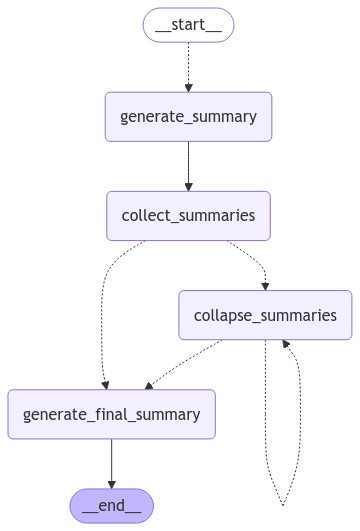

In [46]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### Invoke graph

When running the application, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a [`recursion_limit`](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) on its execution. This will raise a specific error when the specified limit is exceeded.

In [47]:
async for step in app.astream(
    input=OverallState(
        contents=[
            doc.page_content 
            for doc in split_docs
        ]
    ),
    config={
        "recursion_limit": 10
    },
):
    print(list(step.keys())) 

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [48]:
print(step["generate_final_summary"]["final_summary"])

Here is a consolidated summary of the main themes in "The Cask of Amontillado" by Edgar Allan Poe:

"The story revolves around the theme of revenge and its consequences, exploring the darker aspects of human nature and the devastating effects of obsession. The narrative also delves into deception, manipulation, and the blurring of reality and fantasy, as the narrator uses cunning and ruthlessness to lure his acquaintance Fortunato into a trap. Additionally, the story touches on themes of secrets and hidden truths, with the underground vaults serving as a symbol of confinement and isolation. Ultimately, "The Cask of Amontillado" is a masterful exploration of the human psyche, revealing how seemingly innocent actions can lead to sinister consequences."


In the corresponding [LangSmith trace](https://smith.langchain.com/public/f14d42d4-51fa-4dcf-9475-da0a602a6b4f/r) we can see the individual LLM calls, grouped under their respective nodes.

> Check out the following guide on the details of `Map-Reduce` in LangGraph: 
> 
> [How to create map-reduce branches for parallel execution](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)